In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [13]:
"""
NOTE: FIPS codes are 5 digit strings for each county in the US
The first two digits are for the state (so each state has a two character code)
#and the last 3 are for the county, but all 5 are used to refer to the county

Virginia FIPS is 51
"""
#To convert between state name representations
state_to_stfips_path ="/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/misc_data/stfips_to_state.csv"
state_to_stfips_df = pd.read_csv(state_to_stfips_path, header=None, dtype={"2":str})
state_to_stfips_df[2] = state_to_stfips_df[2].astype(str).str.zfill(2)
state_to_stfips = state_to_stfips_df.set_index(0)[2].to_dict()
abbr_to_stfips = state_to_stfips_df.set_index(1)[2].to_dict()

#To hold the population of each FIPS
fips_to_pop = pd.read_csv("/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/misc_data/co-est2019-alldata.csv", encoding="latin-1")
fips_to_pop["fips"] = fips_to_pop.STATE.astype(str).str.zfill(2) + fips_to_pop.COUNTY.astype(str).str.zfill(3).replace("000", "")
fips_to_pop = fips_to_pop.set_index("fips")["POPESTIMATE2019"].to_dict()

#Add some terrotory populations
fips_to_pop["60"] = 55312
fips_to_pop["66"] = 165768
fips_to_pop["69"] = 56882
fips_to_pop["72"] = 2849276
fips_to_pop["78"] = 106977

In [20]:
"""
To get state level cases
"""
state_level_cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/NyTimes/us-states.csv", parse_dates=["date"], dtype={"fips":str})

state_level_cases_cumulative = state_level_cases.pivot(index="date", columns="fips", values="cases")
state_level_cases_incidence = state_level_cases.pivot(index="date", columns="fips", values="cases").diff()

In [22]:
"""
To get county level cases
"""
county_level_cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/NyTimes/us-counties.csv", parse_dates=["date"], dtype={"fips":str})

county_level_cases_cumulative = county_level_cases.pivot_table(index="date", columns="fips", values="cases", aggfunc=np.mean)
county_level_cases_incidence = county_level_cases.pivot_table(index="date", columns="fips", values="cases", aggfunc=np.mean).diff()

In [30]:
"""
To convert, e.g. state, cases to cases per 100k population
"""
state_level_cases_incidence_per_100k = state_level_cases_incidence.apply(lambda col: col / (fips_to_pop[col.name] / 100000), axis=0)

In [34]:
"""
To get state level variant samples (by FIPS). One line per sample from GISAID and NCBI, after deduplication of submissions
"""
state_level_variants = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/variants/variant_samples_by_state.csv", parse_dates=["date", "submission_date"], dtype={"state":str})

In [37]:
"""
To get VA variant prevalence, and number of samples, by fortnight
"""
va_variants = state_level_variants[state_level_variants.state == "51"]
va_variants["count"] = 1
va_variants = va_variants.pivot_table(index="date", columns="variant", values="count", aggfunc=sum)
va_variants = va_variants.resample("14D").sum().replace(0, np.nan)
va_variant_prevalence = va_variants.apply(lambda col: col / va_variants.sum(axis=1), axis=0)
va_samples = va_variants.sum(axis=1)

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(0.5, 1.0, 'Min Prevalence Detectable')

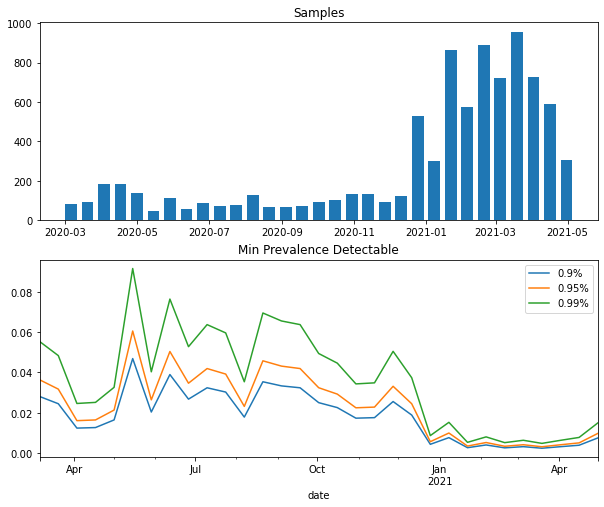

In [40]:
"""
Plot the number of samples, and minimum prevalence detectable with that sample count (Phi from the UT site)
"""

def apply_confidence_bound(col, prob):
    return 1 - (1 - prob)**(1/col)

sample_bounds = pd.DataFrame(va_samples, columns=["samples"])

for confidence in [0.9, 0.95, 0.99]:
    sample_bounds[f"{confidence}%"] = apply_confidence_bound(sample_bounds.samples, confidence)

fig, axs = plt.subplots(2, figsize=(10,8))

axs[0].bar(sample_bounds.index, sample_bounds.samples, width=10)
sample_bounds.drop(columns=["samples"]).plot(ax=axs[1])

axs[0].set_title("Samples")
axs[1].set_title("Min Prevalence Detectable")